# Public Illumination Inspection Route - Rome

This notebook solves the **Chinese Postman Problem** to find the optimal route for inspecting public street lighting in any neighbourhood of Rome.

**Goal**: Create a route that covers all main roads (with street lighting) at least once, minimizing total travel distance.

**Method**: 
1. Define area of interest (multiple input methods supported)
2. Download street network
3. Filter to drivable roads likely to have illumination
4. Solve Chinese Postman Problem
5. Visualize route
6. Export to GPX for navigation

In [1]:
# Install dependencies if needed
# !uv pip install --system --quiet osmnx networkx gpxpy

In [2]:
import networkx as nx
import osmnx as ox
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from datetime import datetime
import gpxpy
import gpxpy.gpx
import os

# Create data directory if it doesn't exist
os.makedirs('./data', exist_ok=True)

print(f"OSMnx version: {ox.__version__}")

OSMnx version: 2.0.5


## 1. Define Area of Interest

Choose one of the following methods to define your inspection area:

Using input method: address
Geocoding address: Via di Centocelle, 301, 00175 Roma, Italia
Coordinates: (41.8652544, 12.554889)

✓ Network downloaded: 128 nodes, 229 edges


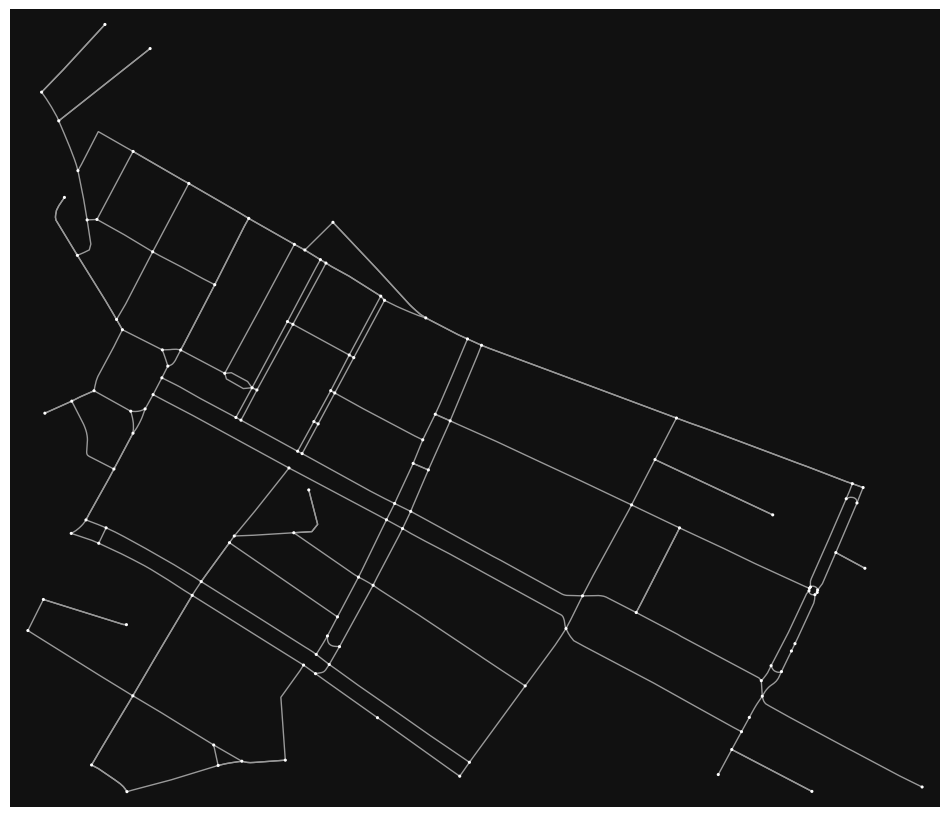

In [3]:
# ============================================
# CONFIGURATION: Choose ONE method below
# ============================================

# METHOD 1: Named place (must be recognized by OpenStreetMap)
# INPUT_METHOD = "place"
# PLACE_NAME = "E.U.R:, Rome, Italy"

# # METHOD 2: Bounding box (north, south, east, west)
# INPUT_METHOD = "bbox"
# BBOX = (12.498224296298567, 41.8729597599347, 12.539938009006285, 41.89193875069077)  # (left, bottom, right, top)

# METHOD 3: Center point + radius
# INPUT_METHOD = "point"
# CENTER_POINT = (41.8853, 12.4683)  # (latitude, longitude) - Trastevere center
# RADIUS = 800  # meters

# METHOD 4: Address + radius (geocoded)
INPUT_METHOD = "address"
ADDRESS = "Via di Centocelle, 301, 00175 Roma, Italia"
RADIUS = 500  # meters

# METHOD 5: Custom polygon (list of [lon, lat] coordinates)
# INPUT_METHOD = "polygon"
# POLYGON_COORDS = [
#     [12.4630, 41.8902],
#     [12.4730, 41.8902],
#     [12.4730, 41.8802],
#     [12.4630, 41.8802],
#     [12.4630, 41.8902]
# ]

# ============================================
# Download network based on selected method
# ============================================

print(f"Using input method: {INPUT_METHOD}")

if INPUT_METHOD == "place":
    print(f"Downloading network for: {PLACE_NAME}")
    G = ox.graph_from_place(PLACE_NAME, network_type="drive")
    area_name = PLACE_NAME.split(',')[0]
    
elif INPUT_METHOD == "bbox":
    print(f"Downloading network for bounding box: {BBOX}")
    G = ox.graph_from_bbox(BBOX, network_type="drive")
    area_name = f"Area ({BBOX[1]:.4f},{BBOX[3]:.4f})"
    
elif INPUT_METHOD == "point":
    print(f"Downloading network around point {CENTER_POINT} with radius {RADIUS}m")
    G = ox.graph_from_point(CENTER_POINT, dist=RADIUS, network_type="drive")
    area_name = f"Area around ({CENTER_POINT[0]:.4f},{CENTER_POINT[1]:.4f})"
    
elif INPUT_METHOD == "address":
    print(f"Geocoding address: {ADDRESS}")
    location = ox.geocode(ADDRESS)
    print(f"Coordinates: {location}")
    print(f"Downloading network with radius {RADIUS}m")
    G = ox.graph_from_address(ADDRESS, dist=RADIUS, network_type="drive")
    area_name = ADDRESS.split(',')[0]
    
elif INPUT_METHOD == "polygon":
    print(f"Downloading network for custom polygon with {len(POLYGON_COORDS)} points")
    from shapely.geometry import Polygon
    polygon = Polygon(POLYGON_COORDS)
    G = ox.graph_from_polygon(polygon, network_type="drive")
    area_name = "Custom area"
    
else:
    raise ValueError(f"Unknown INPUT_METHOD: {INPUT_METHOD}")

print(f"\n✓ Network downloaded: {len(G.nodes)} nodes, {len(G.edges)} edges")
fig, ax = ox.plot_graph(G, node_size=5, figsize=(12, 12))
# plt.title(f"Street Network - {area_name}", fontsize=14)

## 2. Filter to Main Roads (likely with illumination)

We'll focus on primary, secondary, tertiary, and residential roads - these typically have street lighting and are suitable for car-based inspection.

Road types in network:
highway
residential      153
tertiary          16
primary           11
unclassified       3
secondary          1
living_street      1
Name: count, dtype: int64

Filtered network: 127 nodes, 184 edges


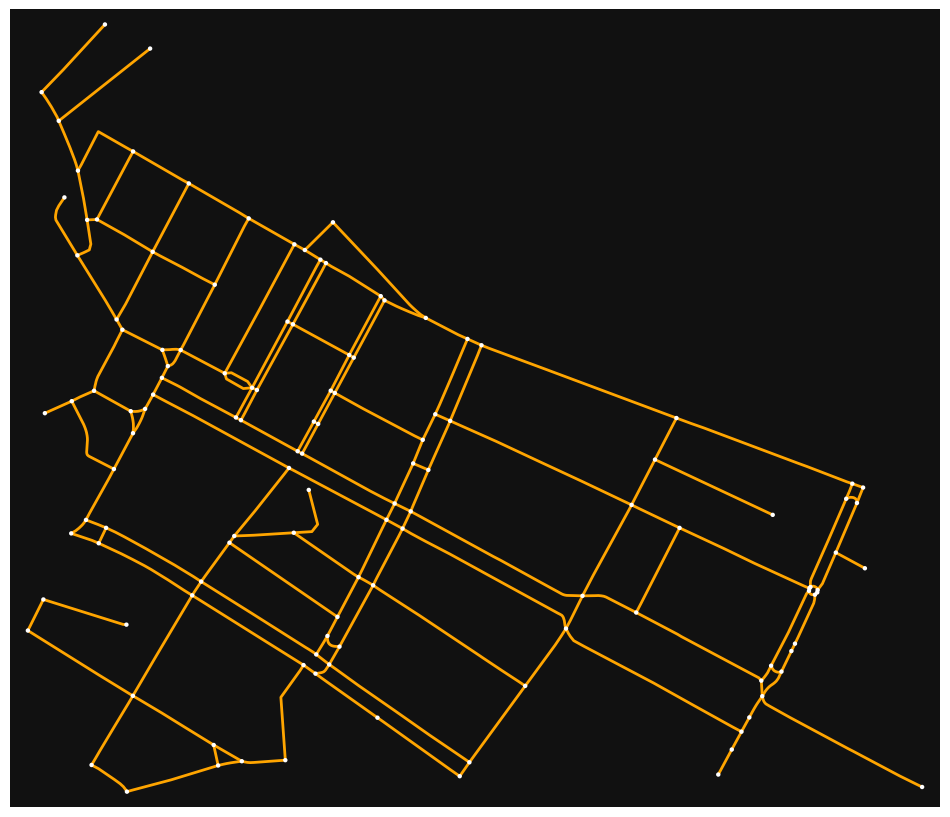

In [4]:
# Convert to undirected for Chinese Postman Problem
G_undirected = ox.convert.to_undirected(G)

# Get edge dataframe to inspect road types
gdf_edges = ox.graph_to_gdfs(G_undirected, nodes=False)

print("Road types in network:")
print(gdf_edges['highway'].value_counts())

# Filter to main roads (likely to have illumination)
# Include: primary, secondary, tertiary, residential, unclassified
main_road_types = ['primary', 'secondary', 'tertiary', 'residential',
                   'primary_link', 'secondary_link', 'tertiary_link', 'unclassified']

# Filter edges
def edge_has_main_road(edge_data):
    highway = edge_data.get('highway', '')
    if isinstance(highway, list):
        return any(h in main_road_types for h in highway)
    return highway in main_road_types

edges_to_remove = [(u, v, k) for u, v, k, data in G_undirected.edges(keys=True, data=True)
                   if not edge_has_main_road(data)]

G_filtered = G_undirected.copy()
G_filtered.remove_edges_from(edges_to_remove)

# Remove isolated nodes
G_filtered.remove_nodes_from(list(nx.isolates(G_filtered)))

print(f"\nFiltered network: {len(G_filtered.nodes)} nodes, {len(G_filtered.edges)} edges")
fig, ax = ox.plot_graph(G_filtered, node_size=10, figsize=(12, 12),
                        edge_color='orange', edge_linewidth=2)

## 3. Solve Chinese Postman Problem

The Chinese Postman Problem finds the shortest route that visits every edge at least once.

**Algorithm**:
1. Find all nodes with odd degree
2. Find minimum weight matching between odd-degree nodes
3. Add duplicate edges from matching
4. Find Eulerian circuit in the resulting graph

In [5]:
# Check if graph is connected
if not nx.is_connected(G_filtered):
    print("Graph is not connected. Using largest connected component.")
    largest_cc = max(nx.connected_components(G_filtered), key=len)
    G_filtered = G_filtered.subgraph(largest_cc).copy()
    print(f"Largest component: {len(G_filtered.nodes)} nodes, {len(G_filtered.edges)} edges")

# Check for Eulerian circuit (all nodes have even degree)
odd_degree_nodes = [node for node, degree in G_filtered.degree() if degree % 2 == 1]
print(f"\nNodes with odd degree: {len(odd_degree_nodes)}")

if len(odd_degree_nodes) == 0:
    print("Graph is Eulerian! Can traverse all edges exactly once.")
else:
    print(f"Graph requires {len(odd_degree_nodes)//2} duplicate edges to make Eulerian.")


Nodes with odd degree: 90
Graph requires 45 duplicate edges to make Eulerian.


In [6]:
# Add edge travel times for routing
G_filtered = ox.add_edge_speeds(G_filtered)
G_filtered = ox.add_edge_travel_times(G_filtered)

# Use length as weight for CPP
for u, v, data in G_filtered.edges(data=True):
    if 'length' not in data:
        data['length'] = 100  # default length if missing

In [7]:
def solve_chinese_postman(G):
    """
    Solve Chinese Postman Problem for graph G.
    Returns Eulerian circuit as list of nodes.
    """
    # Find nodes with odd degree
    odd_nodes = [node for node, degree in G.degree() if degree % 2 == 1]

    if len(odd_nodes) == 0:
        # Already Eulerian
        print("Graph is already Eulerian")
        eulerian_circuit = list(nx.eulerian_circuit(G, source=list(G.nodes())[0]))
        return [u for u, v in eulerian_circuit] + [eulerian_circuit[-1][1]]

    # Create complete graph of odd-degree nodes with shortest path distances
    print(f"Computing shortest paths between {len(odd_nodes)} odd-degree nodes...")
    odd_graph = nx.Graph()

    for i, u in enumerate(odd_nodes):
        for v in odd_nodes[i+1:]:
            try:
                length = nx.shortest_path_length(G, u, v, weight='length')
                odd_graph.add_edge(u, v, weight=length)
            except nx.NetworkXNoPath:
                pass

    # Find minimum weight perfect matching
    print("Finding minimum weight matching...")
    matching = nx.min_weight_matching(odd_graph)

    # Add duplicate edges to make graph Eulerian
    G_euler = G.copy()
    total_added_length = 0

    for u, v in matching:
        path = nx.shortest_path(G, u, v, weight='length')
        path_length = nx.shortest_path_length(G, u, v, weight='length')
        total_added_length += path_length

        # Add edges from shortest path
        for i in range(len(path) - 1):
            G_euler.add_edge(path[i], path[i+1],
                           length=G[path[i]][path[i+1]][0]['length'])

    print(f"Added {total_added_length:.0f}m of duplicate edges")

    # Find Eulerian circuit
    print("Computing Eulerian circuit...")
    eulerian_circuit = list(nx.eulerian_circuit(G_euler, source=odd_nodes[0]))
    route = [u for u, v in eulerian_circuit] + [eulerian_circuit[-1][1]]

    return route

# Solve CPP
route = solve_chinese_postman(G_filtered)
print(f"\nRoute computed: {len(route)} nodes")

Computing shortest paths between 90 odd-degree nodes...
Finding minimum weight matching...
Added 2923m of duplicate edges
Computing Eulerian circuit...

Route computed: 242 nodes


In [8]:
# Calculate route statistics
total_distance = 0
for i in range(len(route) - 1):
    u, v = route[i], route[i+1]
    total_distance += G_filtered[u][v][0]['length']

network_length = sum(data['length'] for u, v, data in G_filtered.edges(data=True))

print(f"Total network length: {network_length/1000:.2f} km")
print(f"Optimal route length: {total_distance/1000:.2f} km")
print(f"Efficiency: {network_length/total_distance*100:.1f}% (percentage of route that is unique roads)")
print(f"Duplicate distance: {(total_distance - network_length)/1000:.2f} km")

Total network length: 11.48 km
Optimal route length: 14.41 km
Efficiency: 79.7% (percentage of route that is unique roads)
Duplicate distance: 2.92 km


## 4. Visualize the Route

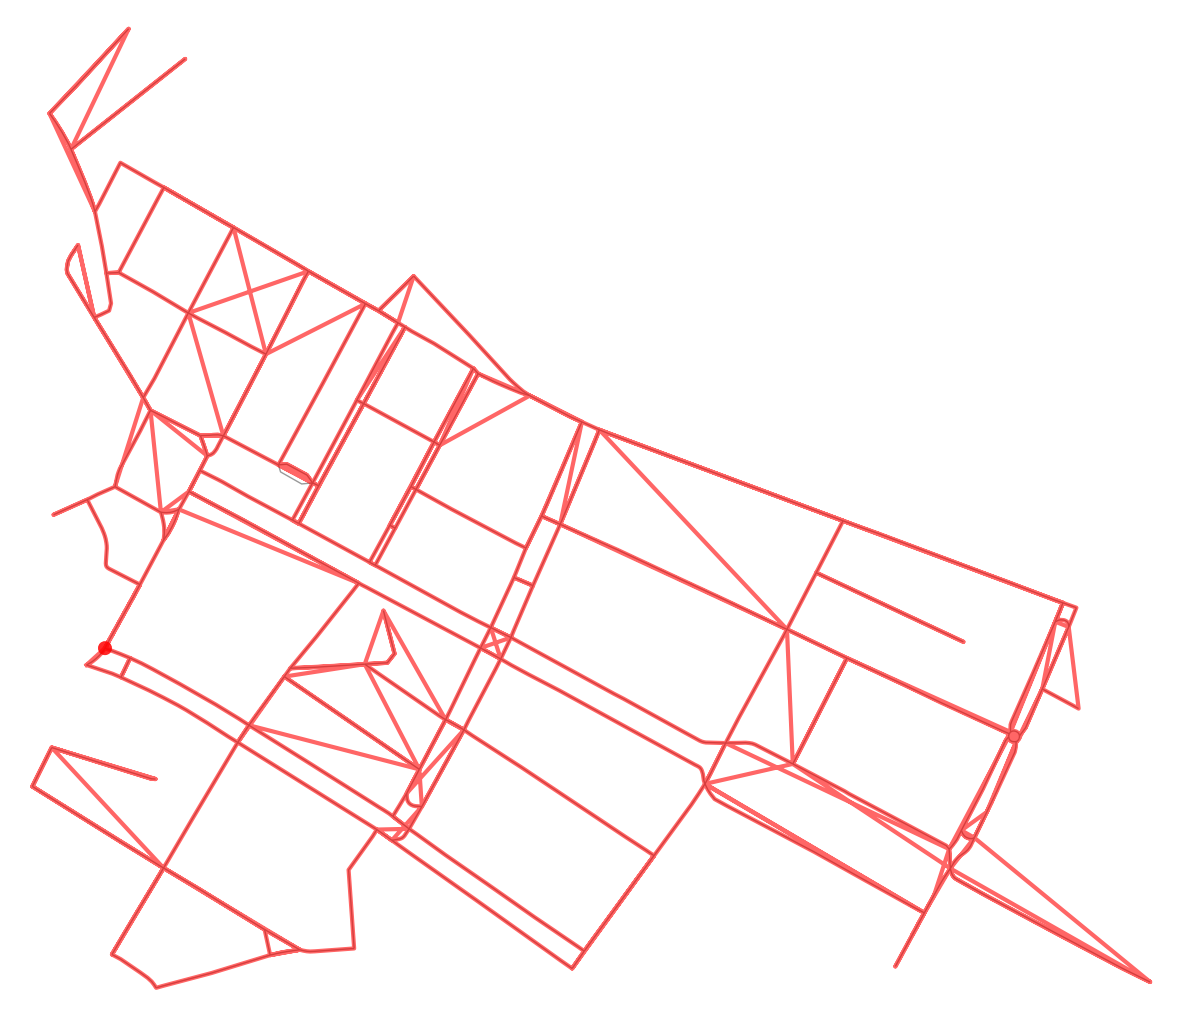

In [9]:
# Plot the route
fig, ax = ox.plot_graph_route(G_filtered, route, 
                               route_color='red', 
                               route_linewidth=3,
                               route_alpha=0.6,
                               node_size=0,
                               bgcolor='white',
                               figsize=(15, 15))

# # Mark start/end point
# start_node = route[0]
# ax.scatter(G_filtered.nodes[start_node]['x'],
#           G_filtered.nodes[start_node]['y'],
#           c='green', s=200, zorder=3, marker='o', label='Start/End')
# ax.legend(fontsize=12)
# plt.title(f'Public Illumination Inspection Route - {area_name}\n'
#           f'Total Distance: {total_distance/1000:.2f} km', fontsize=14)
# plt.tight_layout()

## 5. Export Route for Navigation

In [10]:
# Export route to GPX file
def route_to_gpx(G, route, filename, route_name):
    """
    Export route to GPX file for GPS navigation.
    """
    gpx = gpxpy.gpx.GPX()
    
    # Create track
    gpx_track = gpxpy.gpx.GPXTrack()
    gpx_track.name = route_name
    gpx.tracks.append(gpx_track)
    
    # Create segment
    gpx_segment = gpxpy.gpx.GPXTrackSegment()
    gpx_track.segments.append(gpx_segment)
    
    # Add points
    for node in route:
        gpx_segment.points.append(
            gpxpy.gpx.GPXTrackPoint(
                latitude=G.nodes[node]['y'],
                longitude=G.nodes[node]['x']
            )
        )
    
    # Write to file
    with open(filename, 'w') as f:
        f.write(gpx.to_xml())
    
    print(f"Route exported to {filename}")
    print(f"Contains {len(route)} waypoints")

# Generate filename based on area
safe_filename = area_name.replace(' ', '_').replace(',', '').lower()
gpx_filename = f'./data/{safe_filename}_illumination_route.gpx'

route_to_gpx(G_filtered, route, gpx_filename, f'{area_name} Illumination Inspection')

Route exported to ./data/via_di_centocelle_illumination_route.gpx
Contains 242 waypoints


In [11]:
# Export route as CSV with coordinates and turn-by-turn info
route_data = []
cumulative_distance = 0

for i in range(len(route) - 1):
    u, v = route[i], route[i+1]
    edge_data = G_filtered[u][v][0]
    
    segment_distance = edge_data['length']
    cumulative_distance += segment_distance
    
    route_data.append({
        'step': i + 1,
        'from_node': u,
        'to_node': v,
        'lat': G_filtered.nodes[u]['y'],
        'lon': G_filtered.nodes[u]['x'],
        'street_name': edge_data.get('name', 'Unnamed'),
        'segment_distance_m': round(segment_distance, 1),
        'cumulative_distance_km': round(cumulative_distance/1000, 2)
    })

route_df = pd.DataFrame(route_data)

# Generate filename based on area
csv_filename = f'./data/{safe_filename}_illumination_route.csv'
route_df.to_csv(csv_filename, index=False)

print(f"Route exported to {csv_filename}")
print(f"\nFirst 10 steps:")
route_df.head(10)

Route exported to ./data/via_di_centocelle_illumination_route.csv

First 10 steps:


,step,from_node,to_node,lat,lon,street_name,segment_distance_m,cumulative_distance_km
0,1,260196314,1341623012,41.863488,12.549706,Via Tuscolana,22.3,0.02
1,2,1341623012,925227793,41.863354,12.549510,Via Tuscolana,32.3,0.05
2,3,925227793,925227761,41.863256,12.549876,Via Tuscolana,18.9,0.07
3,4,925227761,925227793,41.863409,12.549975,Via Tuscolana,18.9,0.09
4,5,925227793,302217312,41.863256,12.549876,Via Tuscolana,118.4,0.21
5,6,302217312,302218129,41.862738,12.551123,Via Tuscolana,145.1,0.36
6,7,302218129,926337827,41.862046,12.552608,Via Tuscolana,16.3,0.37
7,8,926337827,302237730,41.861961,12.552768,Via Tuscolana,84.0,0.46
8,9,302237730,302222503,41.861523,12.553595,Via Tuscolana,111.5,0.57
9,10,302222503,302170605,41.860942,12.554692,Unnamed,18.7,0.59


## Summary

This notebook:
1. ✅ Defined area of interest using flexible input methods
2. ✅ Downloaded the street network
3. ✅ Filtered to main drivable roads (likely with street lighting)
4. ✅ Solved the Chinese Postman Problem to find optimal inspection route
5. ✅ Visualized the route on a map
6. ✅ Exported to GPX (for GPS navigation) and CSV (for planning)

**Input Methods Available**:
- **Named place**: Use OpenStreetMap place names (e.g., "Trastevere, Roma, Italia")
- **Bounding box**: Define rectangular area with N, S, E, W coordinates
- **Center point + radius**: Specify lat/lon and distance in meters
- **Address + radius**: Geocode any address and set inspection radius
- **Custom polygon**: Draw exact boundaries using coordinate list

**Usage**:
- Load the GPX file into any GPS navigation app (Google Maps, Waze, etc.)
- Use the CSV file to plan inspection stops and track progress
- The route ensures all main streets are covered with minimum duplicate travel

**To use for a different area**: Simply change the `INPUT_METHOD` variable and corresponding parameters in the configuration section, then re-run all cells.